# Cell 1: Imports and Configuration

In [1]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Set random seeds for reproducibility
def set_seed(seed=12):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Configuration
CONFIG = {
    'IMG_SIZE': 256,
    'BATCH_SIZE': 4,
    'EPOCHS': 100,
    'LR': 0.0001,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'RAW_DATA_PATH': '/kaggle/input/data-science-bowl-2018',
    'WORK_DIR': '/kaggle/working/data', # We extract here because input is read-only
    'CHECKPOINT_PATH': 'best_model.pth'
}

print(f"Device: {CONFIG['DEVICE']}")

Device: cuda


# Cell 2: Data Unzipping and Preprocessing

Extracting /kaggle/input/data-science-bowl-2018/stage1_train.zip to /kaggle/working/data...
Extraction complete.


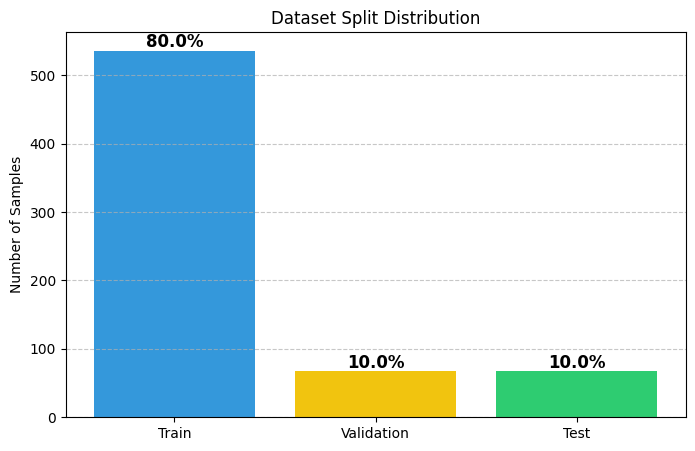

In [2]:
def prepare_data(source_path, target_path):
    """
    Extracts the zip file to a working directory to allow mask merging and standard loading.
    """
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    
    # Path to the specific zip file in the input directory
    zip_path = os.path.join(source_path, 'stage1_train.zip')
    
    print(f"Extracting {zip_path} to {target_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_path)
    print("Extraction complete.")

# Run preparation
prepare_data(CONFIG['RAW_DATA_PATH'], CONFIG['WORK_DIR'])

def get_image_ids(data_dir):
    return [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

all_ids = get_image_ids(CONFIG['WORK_DIR'])

# 80% Train, 10% Val, 10% Test
train_ids, test_val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(test_val_ids, test_size=0.5, random_state=42)

# Visual Output 1: Distribution Histogram
def plot_split_distribution(train, val, test):
    labels = ['Train', 'Validation', 'Test']
    counts = [len(train), len(val), len(test)]
    percentages = [c / sum(counts) * 100 for c in counts]
    
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, counts, color=['#3498db', '#f1c40f', '#2ecc71'])
    
    for bar, p in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{p:.1f}%', 
                 ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.title('Dataset Split Distribution')
    plt.ylabel('Number of Samples')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_split_distribution(train_ids, val_ids, test_ids)

# Cell 3: Consolidated Model Architecture
Consolidated parts 1-4 into a single block, removing relative imports to ensure execution.

In [3]:
# --- Part 1: UNet Helpers (DoubleConv, Down, Up, OutConv) ---
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# --- Part 2: Attention Components (MultiConv, PAM, PosEmbedding, SDPA) ---
class MultiConv(nn.Module):
    def __init__(self, in_ch, out_ch, attn=True):
        super(MultiConv, self).__init__()
        self.fuse_attn = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.PReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.PReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=1),
            nn.BatchNorm2d(out_ch),
            nn.Softmax2d() if attn else nn.PReLU()
        )

    def forward(self, x):
        return self.fuse_attn(x)


class PAM_Module(nn.Module):
    """Spatial Attention Module"""
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height)

        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma * out + x
        return out


class PositionEmbeddingLearned(nn.Module):
    """Learned Position Embedding"""
    def __init__(self, num_pos_feats=256, len_embedding=32):
        super().__init__()
        self.row_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.col_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, tensor_list):
        x = tensor_list
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)

        x_emb = self.col_embed(i)
        y_emb = self.row_embed(j)

        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)

        return pos


class ScaledDotProductAttention(nn.Module):
    '''Self-Attention Module'''
    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature ** 0.5
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, x, mask=None):
        m_batchsize, d, height, width = x.size()
        q = x.view(m_batchsize, d, -1)
        k = x.view(m_batchsize, d, -1)
        k = k.permute(0, 2, 1)
        v = x.view(m_batchsize, d, -1)

        attn = torch.matmul(q / self.temperature, k)

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)
        output = output.view(m_batchsize, d, height, width)

        return output


# --- Part 3: Main Architecture Class ---
class UNet_Attention_Transformer_Multiscale(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(1024, 256 // factor, bilinear)
        self.up3 = Up(512, 128 // factor, bilinear)
        self.up4 = Up(256, 64, bilinear)
        self.outc = OutConv(128, n_classes)

        '''Position Embedding'''
        self.pos = PositionEmbeddingLearned(512 // factor)

        '''Spatial Attention'''
        self.pam = PAM_Module(512)

        '''Self Attention'''
        self.sdpa = ScaledDotProductAttention(512)

        '''Residual Multiscale Connections'''
        self.fuse1 = MultiConv(768, 256)
        self.fuse2 = MultiConv(384, 128)
        self.fuse3 = MultiConv(192, 64)
        self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        '''Setting 1'''
        x5_pam = self.pam(x5)

        '''Setting 2'''
        x5_pos = self.pos(x5)
        x5 = x5 + x5_pos

        x5_sdpa = self.sdpa(x5)
        x5 = x5_sdpa + x5_pam
        
        x6 = self.up1(x5, x4)
        x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
        x6_cat = torch.cat((x5_scale, x6), 1)

        x7 = self.up2(x6_cat, x3)
        x6_scale = F.interpolate(x6, size=x7.shape[2:], mode='bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        x8 = self.up3(x7_cat, x2)
        x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
        x8_cat = torch.cat((x7_scale, x8), 1)

        x9 = self.up4(x8_cat, x1)
        x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
        x9 = torch.cat((x8_scale, x9), 1)

        logits = self.outc(x9)
        return logits

# Cell 4: Dataset Class and Utilities

In [4]:
class DSBDataset(Dataset):
    def __init__(self, root_dir, id_list, transform=None):
        self.root_dir = root_dir
        self.id_list = id_list
        self.transform = transform

    def __len__(self):
        return len(self.id_list)

    def __getitem__(self, idx):
        img_id = self.id_list[idx]
        img_path = os.path.join(self.root_dir, img_id, 'images', img_id + '.png')
        mask_dir = os.path.join(self.root_dir, img_id, 'masks')
        
        # Load Image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load and Merge Masks
        masks = []
        for mask_file in os.listdir(mask_dir):
            mask_path = os.path.join(mask_dir, mask_file)
            mask = cv2.imread(mask_path, 0)
            masks.append(mask)
        
        if masks:
            mask = np.maximum.reduce(masks) # Merge masks
        else:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            
        # Resize
        image = cv2.resize(image, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']))
        mask = cv2.resize(mask, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), interpolation=cv2.INTER_NEAREST)
        
        # Normalize and Tensor
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        mask = np.expand_dims(mask, axis=0) # (1, H, W)
        image = np.transpose(image, (2, 0, 1)) # (3, H, W)
        
        return torch.tensor(image), torch.tensor(mask)

def get_loaders():
    train_ds = DSBDataset(CONFIG['WORK_DIR'], train_ids)
    val_ds = DSBDataset(CONFIG['WORK_DIR'], val_ids)
    test_ds = DSBDataset(CONFIG['WORK_DIR'], test_ids)
    
    train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader, test_ds

# --- Metrics & Loss ---
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum()
        union = probs.sum() + targets.sum()
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, inputs, targets):
        return 0.5 * self.bce(inputs, targets) + 0.5 * self.dice(inputs, targets)

def calculate_metrics(logits, targets, threshold=0.5):
    """Calculates Pixel-wise metrics"""
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    
    # Flatten
    preds_f = preds.view(-1)
    targets_f = targets.view(-1)
    
    # Intersection & Union
    intersection = (preds_f * targets_f).sum()
    union = preds_f.sum() + targets_f.sum()
    
    # Dice & IoU
    smooth = 1e-6
    dice = (2. * intersection + smooth) / (union + smooth)
    iou = (intersection + smooth) / (union - intersection + smooth)
    
    # Accuracy (Pixel-wise)
    accuracy = (preds_f == targets_f).float().mean()
    
    # Precision & Recall
    TP = intersection
    FP = preds_f.sum() - TP
    FN = targets_f.sum() - TP
    
    precision = (TP + smooth) / (TP + FP + smooth)
    recall = (TP + smooth) / (TP + FN + smooth)
    
    return dice.item(), iou.item(), accuracy.item(), recall.item(), precision.item()

# Cell 5: Training Pipeline

In [5]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    epoch_acc = 0
    
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        dice, _, acc, _, _ = calculate_metrics(outputs, masks)
        epoch_dice += dice
        epoch_acc += acc
        
    return epoch_loss / len(loader), epoch_dice / len(loader), epoch_acc / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    metrics = {'dice':0, 'iou':0, 'acc':0, 'rec':0, 'prec':0}
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
            
            d, i, a, r, p = calculate_metrics(outputs, masks)
            metrics['dice'] += d
            metrics['iou'] += i
            metrics['acc'] += a
            metrics['rec'] += r
            metrics['prec'] += p
            
    for k in metrics:
        metrics[k] /= len(loader)
        
    return epoch_loss / len(loader), metrics

# Cell 6: Main Execution Loop

In [6]:
# Initialize Model
model = UNet_Attention_Transformer_Multiscale(n_channels=3, n_classes=1).to(CONFIG['DEVICE'])

# Optimizer & Scheduler
optimizer = optim.SGD(model.parameters(), lr=CONFIG['LR'], momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
criterion = CombinedLoss()

# Loaders
train_loader, val_loader, test_loader, test_dataset = get_loaders()

# History Storage
history = {
    'train_loss': [], 'train_dice': [], 'train_acc': [],
    'val_loss': [], 'val_dice': [], 'val_iou': [],
    'val_acc': [], 'val_rec': [], 'val_prec': []
}

best_dice = 0.0

print(f"Starting Training for {CONFIG['EPOCHS']} epochs...")
print("-" * 30)

for epoch in range(CONFIG['EPOCHS']):
    train_loss, train_dice, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, CONFIG['DEVICE'])
    val_loss, val_metrics = validate(model, val_loader, criterion, CONFIG['DEVICE'])
    
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_metrics['dice'])
    history['val_iou'].append(val_metrics['iou'])
    history['val_acc'].append(val_metrics['acc'])
    history['val_rec'].append(val_metrics['rec'])
    history['val_prec'].append(val_metrics['prec'])
    
    # Text Output
    print(f"Epoch {epoch+1}/{CONFIG['EPOCHS']} | "
          f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Dice: {val_metrics['dice']:.4f} | Val Acc: {val_metrics['acc']:.4f}")
    
    # Save Best Model
    if val_metrics['dice'] > best_dice:
        best_dice = val_metrics['dice']
        torch.save(model.state_dict(), CONFIG['CHECKPOINT_PATH'])

print("-" * 30)
print(f"Training Complete. Best Val Dice: {best_dice:.4f}")

Starting Training for 100 epochs...
------------------------------
Epoch 1/100 | Train Loss: 0.6356 | Train Dice: 0.5001 | Train Acc: 0.7896 | Val Loss: 0.6026 | Val Dice: 0.5361 | Val Acc: 0.8277
Epoch 2/100 | Train Loss: 0.4959 | Train Dice: 0.6948 | Train Acc: 0.9038 | Val Loss: 0.4997 | Val Dice: 0.6388 | Val Acc: 0.8865
Epoch 3/100 | Train Loss: 0.4126 | Train Dice: 0.7403 | Train Acc: 0.9215 | Val Loss: 0.4406 | Val Dice: 0.6756 | Val Acc: 0.9040
Epoch 4/100 | Train Loss: 0.3533 | Train Dice: 0.7779 | Train Acc: 0.9364 | Val Loss: 0.4265 | Val Dice: 0.6837 | Val Acc: 0.8992
Epoch 5/100 | Train Loss: 0.3135 | Train Dice: 0.8007 | Train Acc: 0.9434 | Val Loss: 0.3784 | Val Dice: 0.7185 | Val Acc: 0.9173
Epoch 6/100 | Train Loss: 0.2903 | Train Dice: 0.8021 | Train Acc: 0.9470 | Val Loss: 0.2988 | Val Dice: 0.8035 | Val Acc: 0.9527
Epoch 7/100 | Train Loss: 0.2623 | Train Dice: 0.8163 | Train Acc: 0.9513 | Val Loss: 0.2910 | Val Dice: 0.8021 | Val Acc: 0.9522
Epoch 8/100 | Train Los

# Cell 7: Visualization & Plotting

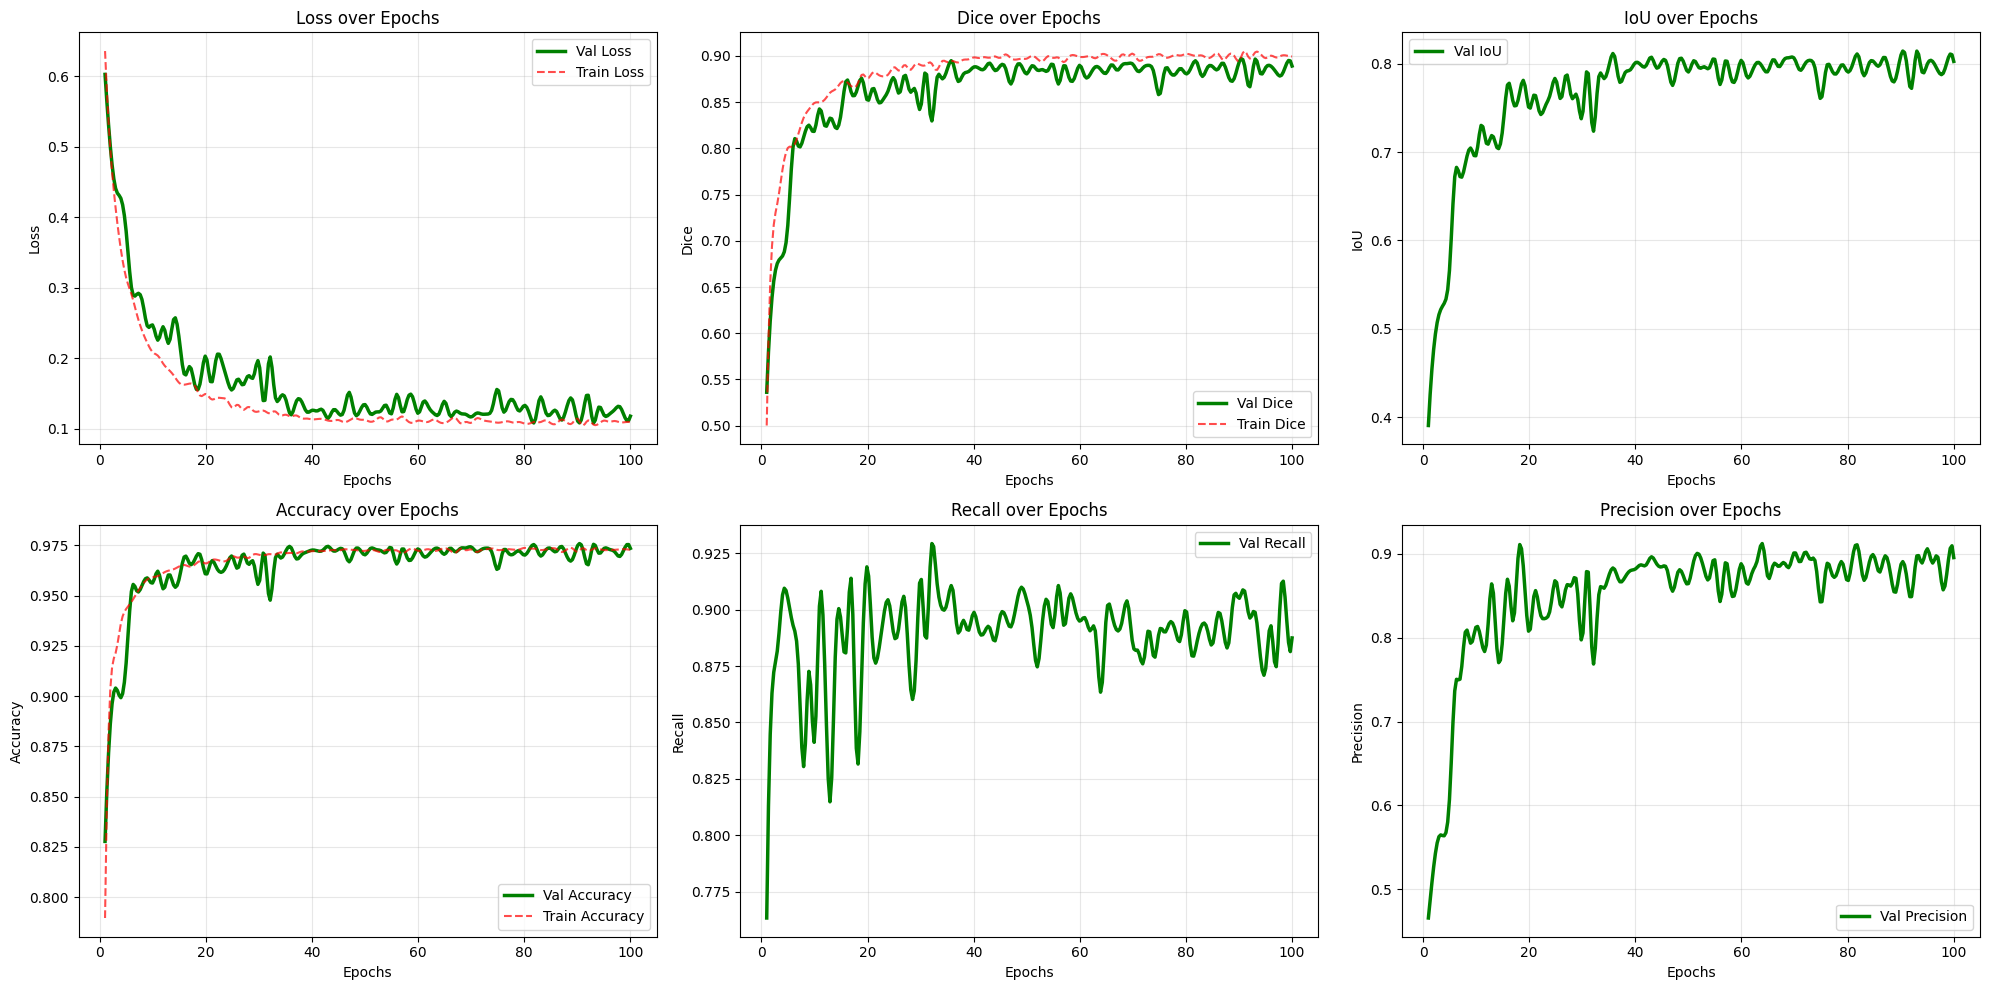

In [7]:
import math
def smooth_curve(x, y):
    # Generates a smooth curve using spline interpolation
    x_new = np.linspace(min(x), max(x), 300) 
    spl = make_interp_spline(x, y, k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

def plot_metrics(history):
    # Define the metrics we want to plot
    metrics_to_plot = [
        ('Loss', 'train_loss', 'val_loss'),
        ('Dice', 'train_dice', 'val_dice'),
        ('IoU', None, 'val_iou'),
        ('Accuracy', 'train_acc', 'val_acc'),
        ('Recall', None, 'val_rec'),
        ('Precision', None, 'val_prec')
    ]
    
    # Dynamic Grid Calculation
    num_metrics = len(metrics_to_plot)
    cols = 3
    rows = math.ceil(num_metrics / cols)  # Calculate rows needed automatically
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(20, 5 * rows)) # Adjust height based on rows
    
    for i, (name, train_key, val_key) in enumerate(metrics_to_plot):
        plt.subplot(rows, cols, i + 1)
        
        # Plot Validation (Green, Solid, Thick)
        if val_key:
            x, y = smooth_curve(epochs, history[val_key])
            plt.plot(x, y, color='green', linewidth=2.5, linestyle='-', label=f'Val {name}')
            
        # Plot Training (Red, Dashed, Thin)
        if train_key:
            x, y = smooth_curve(epochs, history[train_key])
            plt.plot(x, y, color='red', linewidth=1.5, linestyle='--', alpha=0.7, label=f'Train {name}')
            
        plt.title(f'{name} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(name)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()

plot_metrics(history)

# Cell 8: Final Evaluation, Histograms & Comparison

Running Final Evaluation on Test Set...

=== Final Metric Table ===


,Metric,My Model (Test)
0,Dice,0.899537
1,IoU,0.818397
2,Accuracy,0.969342
3,Recall,0.913883
4,Precision,0.888095


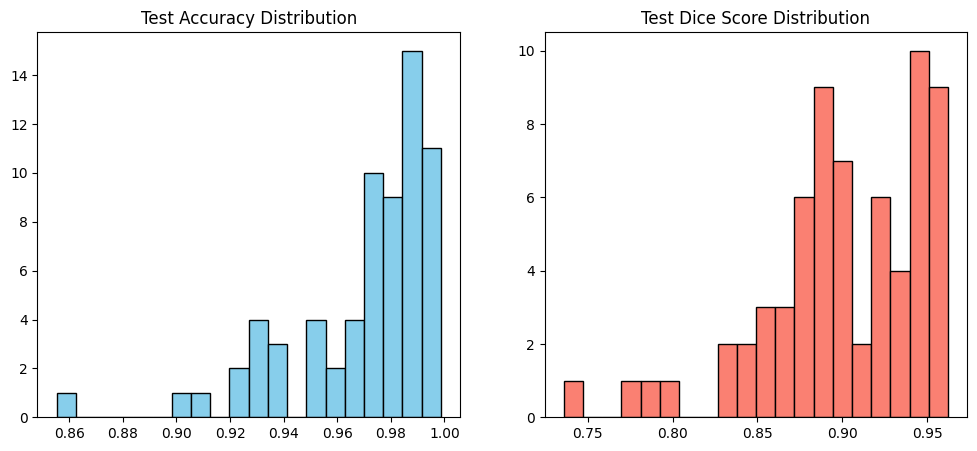

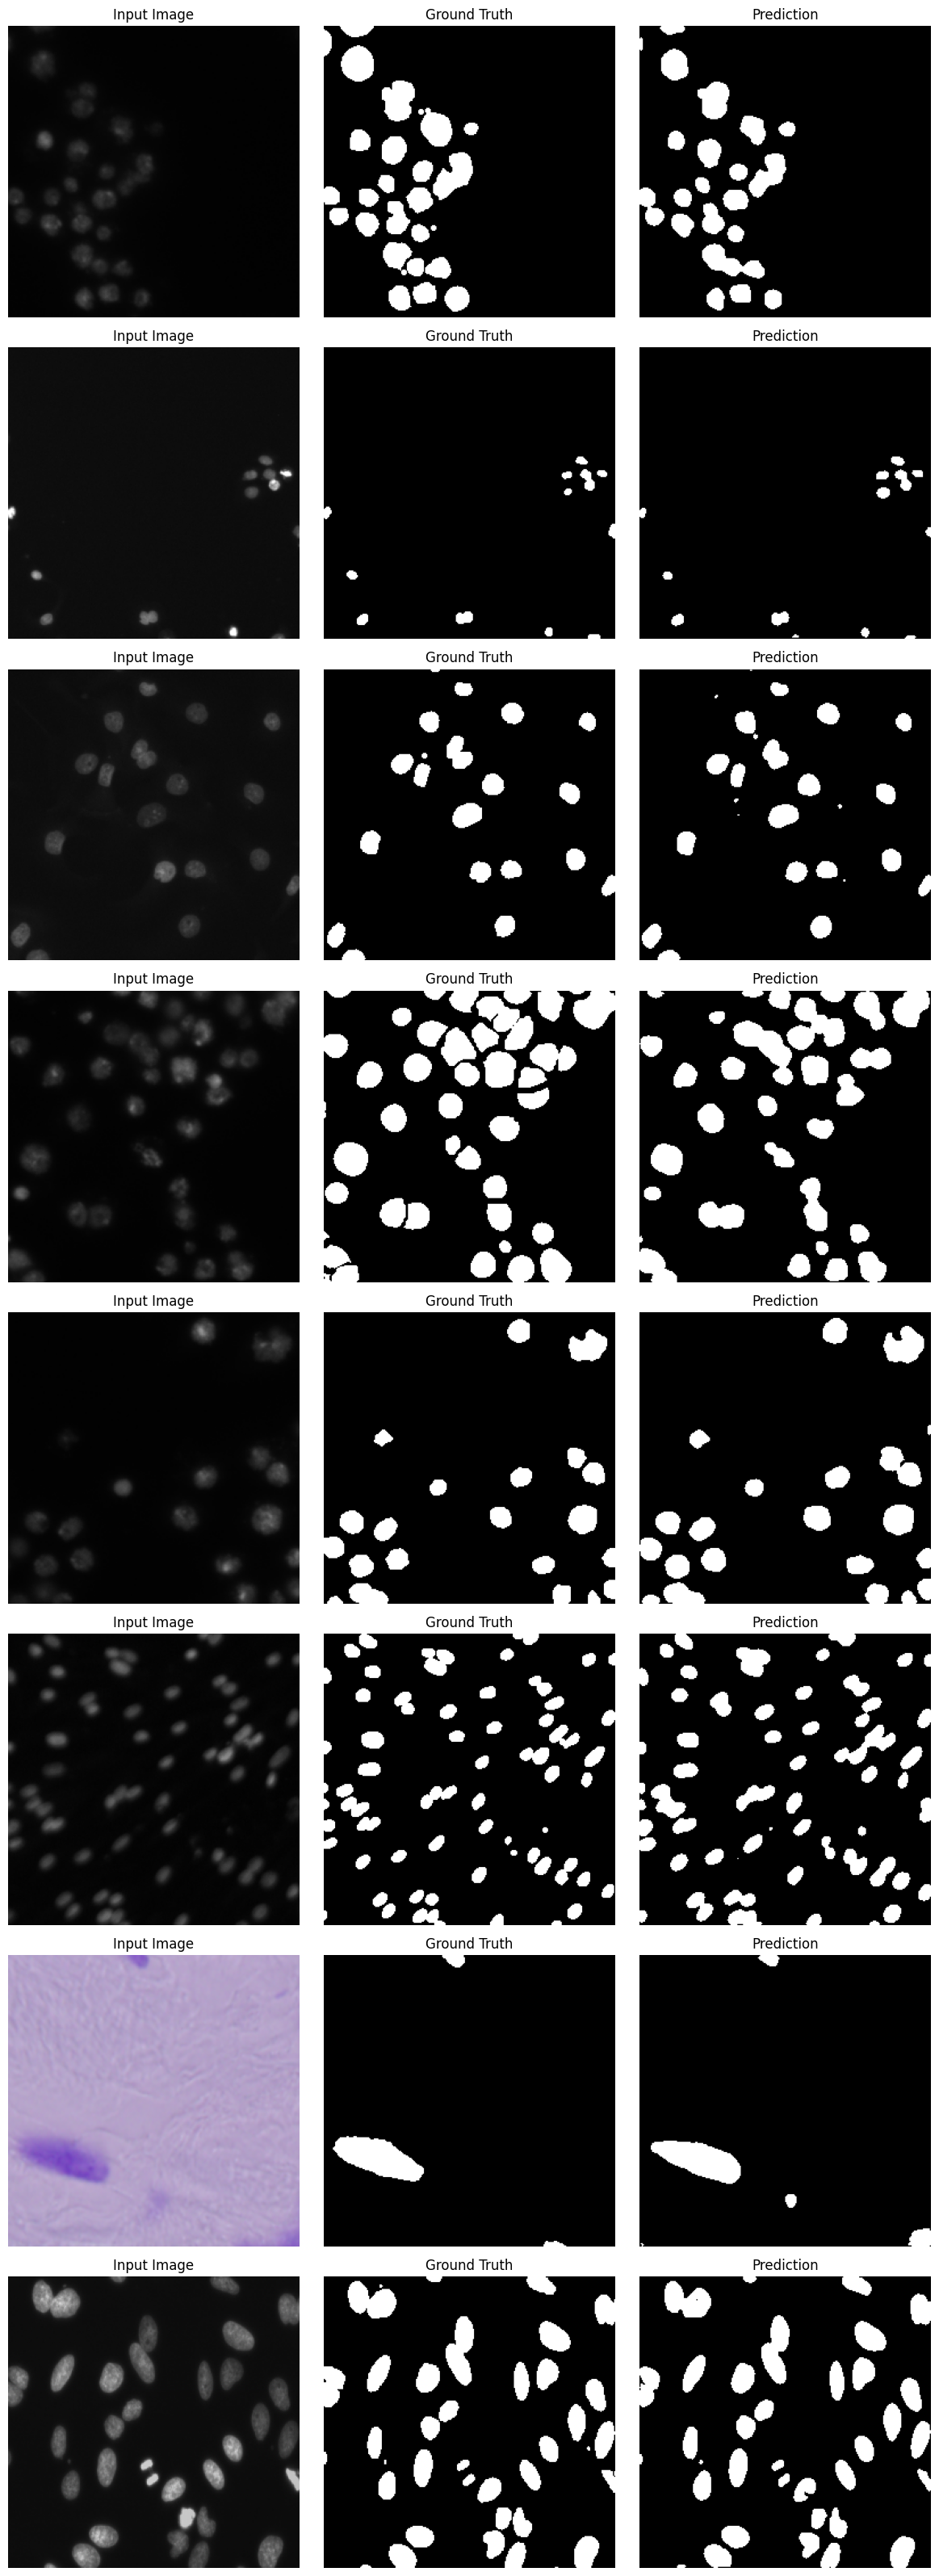


=== Model Comparison vs Paper ===


,Metric,My Model (Test),Paper Reference
0,Dice,89.95%,91.62%
1,IoU,81.84%,84.98%
2,Accuracy,96.93%,97.46%
3,Recall,91.39%,91.85%
4,Precision,88.81%,91.93%


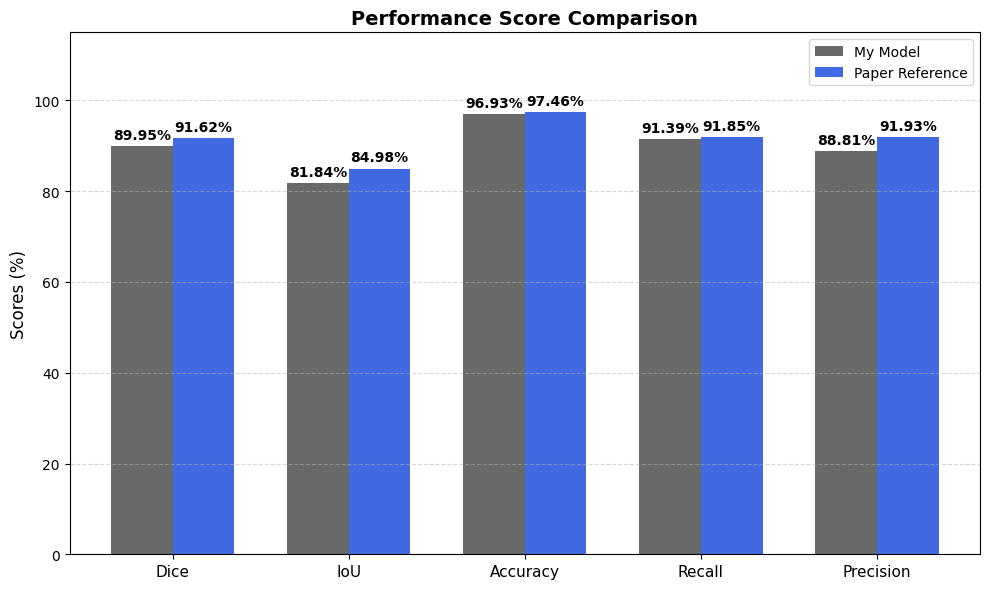

In [8]:
# 1. Load Best Model
model.load_state_dict(torch.load(CONFIG['CHECKPOINT_PATH']))
model.eval()

# 2. Inference on Test Set
test_metrics = {'dice':[], 'iou':[], 'acc':[], 'rec':[], 'prec':[]}
raw_scores = {'acc': [], 'dice': []}

print("Running Final Evaluation on Test Set...")
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(CONFIG['DEVICE'])
        masks = masks.to(CONFIG['DEVICE'])
        outputs = model(images)
        
        # Batch metrics
        d, i, a, r, p = calculate_metrics(outputs, masks)
        
        test_metrics['dice'].append(d)
        test_metrics['iou'].append(i)
        test_metrics['acc'].append(a)
        test_metrics['rec'].append(r)
        test_metrics['prec'].append(p)
        
        # Collect raw scores for histograms
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        for j in range(len(preds)):
            # Per image calculation for histogram distribution
            pdice, piou, pacc, prec, pprec = calculate_metrics(outputs[j:j+1], masks[j:j+1])
            raw_scores['acc'].append(pacc)
            raw_scores['dice'].append(pdice)

# Averages
final_scores = {k: np.mean(v) for k, v in test_metrics.items()}

# 3. Metric Table
results_df = pd.DataFrame({
    'Metric': ['Dice', 'IoU', 'Accuracy', 'Recall', 'Precision'],
    'My Model (Test)': [
        final_scores['dice'], final_scores['iou'], final_scores['acc'], 
        final_scores['rec'], final_scores['prec']
    ]
})
print("\n=== Final Metric Table ===")
display(results_df)

# 4. Histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(raw_scores['acc'], bins=20, color='skyblue', edgecolor='black')
plt.title('Test Accuracy Distribution')
plt.subplot(1, 2, 2)
plt.hist(raw_scores['dice'], bins=20, color='salmon', edgecolor='black')
plt.title('Test Dice Score Distribution')
plt.show()

# 5. Visual Inference (>7 images)
def show_inference(dataset, model, count=8):
    indices = random.sample(range(len(dataset)), count)
    plt.figure(figsize=(12, 4 * count))
    
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        input_tensor = img.unsqueeze(0).to(CONFIG['DEVICE'])
        
        with torch.no_grad():
            pred = model(input_tensor)
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).float()
            
        # Unnormalize image for display
        disp_img = img.permute(1, 2, 0).numpy()
        
        plt.subplot(count, 3, i*3 + 1)
        plt.imshow(disp_img)
        plt.title("Input Image")
        plt.axis('off')
        
        plt.subplot(count, 3, i*3 + 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        plt.subplot(count, 3, i*3 + 3)
        plt.imshow(pred.cpu().squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

show_inference(test_dataset, model, count=8)

# 6. Comparison Table
comparison_df = pd.DataFrame({
    'Metric': ['Dice', 'IoU', 'Accuracy', 'Recall', 'Precision'],
    'My Model (Test)': [
        f"{final_scores['dice']*100:.2f}%", 
        f"{final_scores['iou']*100:.2f}%", 
        f"{final_scores['acc']*100:.2f}%", 
        f"{final_scores['rec']*100:.2f}%", 
        f"{final_scores['prec']*100:.2f}%"
    ],
    'Paper Reference': ['91.62%', '84.98%', '97.46%', '91.85%', '91.93%']
})

print("\n=== Model Comparison vs Paper ===")
display(comparison_df)

plot_df = comparison_df.copy()

cols_to_fix = ['My Model (Test)', 'Paper Reference']
for col in cols_to_fix:
    plot_df[col] = plot_df[col].str.rstrip('%').astype(float)

# --- Plotting ---
metrics = plot_df['Metric']
my_scores = plot_df['My Model (Test)']
paper_scores = plot_df['Paper Reference']

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, my_scores, width, label='My Model', color='#696969') 
rects2 = ax.bar(x + width/2, paper_scores, width, label='Paper Reference', color='#4169E1')

# --- Styling ---
ax.set_ylabel('Scores (%)', fontsize=12)
ax.set_title('Performance Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim(0, 115) 
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [9]:
from IPython.display import FileLink
FileLink(r'best_model.pth')

/kaggle/working/best_model.pth